In [1]:
#import modules 
import pandas as pd #dataframes 
import glob #for pattern checking 
import re  #regular expressions
import numpy as np #numerical computing 
import matplotlib.pyplot as plt #plotting
import seaborn as sns 
from scipy import stats 
from sys import platform #for checking platform 

#change the home directory based on os
if platform == 'linux':
    home = '/home/krista/'
elif platform == 'darwin': 
    home = '/Users/krista/'

data_path=home+'Dropbox/loki_0/simple_rt_experiment_probabilityC/data'
print_data_path=home+'Dropbox/loki_0/simple_rt_experiment_probabilityC/analysis/aggregated_data/'

#cond0: lc
#cond1: hc
#cond2: hv
#cond3: lv

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
#calculate expected number of files for error-checking
n_conditions = 4
n_participants = 24 
n_clean_trials = 600

total_n_files = n_conditions*n_participants
total_n_clean_trials = total_n_files*n_clean_trials
print(total_n_files)
print(total_n_clean_trials)

96
57600


In [4]:
#search for pattern that indicates the dataset
all_data_list = glob.glob(data_path+'/07[0-9][0-9]_cond[0-9]_trialset*[0-9].csv')
len(all_data_list) == total_n_files

#compile regular expressions for ID and condition 
ID_re = re.compile('07[0-9][0-9]')
condition_re = re.compile('cond[0-9]')

#find matching expression in list 
IDs = np.hstack(map(ID_re.findall, all_data_list))
cond_codes = np.hstack(map(condition_re.findall, all_data_list))

#decode condition numbers 
cond_names = ['lc', 'hc', 'hv', 'lv']
decoded_conditions = np.hstack(map(lambda x: cond_names[int(x[-1])], cond_codes))

#check unique IDs and conditions
unique_IDs = np.unique(IDs)
unique_conditions = np.unique(decoded_conditions)

print(unique_IDs)
print(unique_conditions)

print(len(unique_IDs))
print(len(unique_conditions))

['0761' '0762' '0763' '0764' '0765' '0766' '0767' '0768' '0769' '0770'
 '0771' '0772' '0773' '0774' '0775' '0776' '0777' '0778' '0779' '0780'
 '0781' '0782' '0783' '0784']
['hc' 'hv' 'lc' 'lv']
24
4


In [5]:
#construct a dataframe 
data_df = pd.concat((pd.read_csv(d) for d in all_data_list))
#strip whitespace from col. names for indexing later
data_df.columns = data_df.columns.str.strip()

#create vectors of IDs and conditions 
data_df['ID'] =  np.hstack(np.repeat(id, len(pd.read_csv(fname))) for id,fname in zip(IDs,all_data_list))
data_df['condition'] = np.hstack(np.repeat(c, len(pd.read_csv(fname))) for c,fname in zip(decoded_conditions,all_data_list))

#strip leading zeros from IDs
data_df.ID = data_df.ID.str.lstrip('0')


data_df.head(10)
data_df.tail()

#n_trials will be longer than n_clean_trials if repeat trials [too fast/slow]
data_df.shape

(58379, 13)

In [6]:
trial_flags = np.unique(data_df.cp_with_slow_fast)
print(trial_flags)

[-2. -1.  0.  1.]


In [7]:
#find all fast/slow trials
fast_trials = data_df.cp_with_slow_fast == -2
slow_trials = data_df.cp_with_slow_fast == -1
lc = data_df.condition == 'lc'
hc = data_df.condition == 'hc'
lv = data_df.condition == 'lv'
hv = data_df.condition == 'hv'

In [8]:
data_df[fast_trials].rt.head(), data_df[slow_trials].rt.head()

(24     0.094082
 51     0.065540
 78     0.055153
 82     0.059268
 130    0.055171
 Name: rt, dtype: float64, 413    1.008746
 484    1.186953
 13     1.177345
 14     1.921376
 62     1.295908
 Name: rt, dtype: float64)

In [9]:
data_df[lc].head()

,choice,accuracy,solution,reward,cumulative_reward,rt,total_trial_time,iti,cp_with_slow_fast,obs_cp_with_slow_fast,high_val_cue,ID,condition
0,0.0,1.0,0.0,3.0,602.0,0.755284,2.342904,0.594449,0.0,0.0,112.0,777,lc
1,0.0,0.0,1.0,0.0,601.0,0.593914,2.038654,0.466727,0.0,0.0,112.0,777,lc
2,0.0,1.0,0.0,4.0,604.0,0.689023,2.155747,0.472454,0.0,0.0,112.0,777,lc
3,0.0,1.0,0.0,3.0,606.0,0.640144,1.891617,0.264370,0.0,0.0,112.0,777,lc
4,1.0,1.0,1.0,2.0,607.0,0.475835,1.773515,0.321186,0.0,0.0,112.0,777,lc


In [10]:
#clean df 
#only keep trials with 1 or 0 flags (get rid of fast/slow trials)
cleaned_df = data_df[(data_df.cp_with_slow_fast == 1) | (data_df.cp_with_slow_fast == 0)]
#should be equal
print('cleaned df shape matches expected length? ', cleaned_df.shape[0] == total_n_clean_trials)
#should be empty df 
print('trials outside of rt bounds ', cleaned_df[cleaned_df.rt > 1], cleaned_df[cleaned_df.rt < .1])

cleaned df shape matches expected length?  True
trials outside of rt bounds  Empty DataFrame
Columns: [choice, accuracy, solution, reward, cumulative_reward, rt, total_trial_time, iti, cp_with_slow_fast, obs_cp_with_slow_fast, high_val_cue, ID, condition]
Index: [] Empty DataFrame
Columns: [choice, accuracy, solution, reward, cumulative_reward, rt, total_trial_time, iti, cp_with_slow_fast, obs_cp_with_slow_fast, high_val_cue, ID, condition]
Index: []


In [11]:
#harmonic mean for rts [more sensitive to outliers. see facts from figures, ratcliff, etc.]
print('median rt for lc', stats.hmean(cleaned_df.rt[cleaned_df.condition == 'lc'])) 
print('median rt for lv', stats.hmean(cleaned_df.rt[cleaned_df.condition == 'lv']) )
print('median rt for hc', stats.hmean(cleaned_df.rt[cleaned_df.condition == 'hc'])) 
print('median rt for hv', stats.hmean(cleaned_df.rt[cleaned_df.condition == 'hv']) )

median rt for lc 0.304108600242
median rt for lv 0.302178534368
median rt for hc 0.302474393511
median rt for hv 0.311246236919


In [12]:
#median rts 
print('median rt for lc', np.median(cleaned_df.rt[cleaned_df.condition == 'lc'])) 
print('median rt for lv', np.median(cleaned_df.rt[cleaned_df.condition == 'lv']) )
print('median rt for hc', np.median(cleaned_df.rt[cleaned_df.condition == 'hc'])) 
print('median rt for hv', np.median(cleaned_df.rt[cleaned_df.condition == 'hv']) )

median rt for lc 0.304419517517
median rt for lv 0.301387429237
median rt for hc 0.304340004921
median rt for hv 0.311047911644


In [13]:
#create a vector of trial numbers
cleaned_df['trial'] = np.tile(range(0,n_clean_trials), n_participants*n_conditions)
#check that trials were counted correctly 
cleaned_df.groupby(["ID", "condition"])['trial'].count().unique()
#set the first trial as a cp for correct counting of epochs 
cleaned_df.loc[cleaned_df.trial == 0, 'cp_with_slow_fast'] = 1

In [14]:
#create epoch_n variable within each subject & condition 
cleaned_df['epoch_n']=cleaned_df.groupby(["ID", "condition"])["cp_with_slow_fast"].transform(np.cumsum)

In [15]:
#count epoch_trials within each epoch 
cleaned_df['epoch_trial']=cleaned_df.groupby(["ID", "condition", "epoch_n"])['trial'].transform(lambda x: range(0, len(x)))

In [16]:
#get shifted epoch trials
lag=2
cleaned_df['shifted_epoch_trial']=cleaned_df.groupby(["ID", "condition", "epoch_n"])['epoch_trial'].transform(lambda x: x-(abs(x-x.max())<lag)*(x.max()+1))
#if < 2 trials from end, then subtract max + 1 from trials; if not do nothing

In [17]:
#check approx. equal numbers of -1 and -2 shifts (approx. because some epochs == 1 trial)
sum(cleaned_df.groupby(["ID", "condition", "epoch_n"])['shifted_epoch_trial'].tail(2) == -1.), sum(cleaned_df.groupby(["ID", "condition", "epoch_n"])['shifted_epoch_trial'].tail(2) == -2.)

(2564, 2554)

In [18]:
#calc. proportion of trials where one target was rewarded (arbitrarily chosen)
cleaned_df['prop_112']=cleaned_df.groupby(["ID", "condition", "epoch_n"])['high_val_cue'].transform(lambda x: sum(x == 112)/len(x))

#add number of trials per epoch
cleaned_df['n_epoch_trials']=cleaned_df.groupby(["ID", "condition", "epoch_n"])['epoch_trial'].transform(lambda x: x.max()+1)

#calc. high p. & low p. target
cleaned_df.loc[cleaned_df.prop_112 >= 0.5, 'high_p_cue'] = 112
cleaned_df.loc[cleaned_df.prop_112 < 0.5, 'high_p_cue'] = 111

cleaned_df.loc[cleaned_df.high_p_cue == 112, 'low_p_cue'] = 111
cleaned_df.loc[cleaned_df.high_p_cue == 111, 'low_p_cue'] = 112

In [19]:
cleaned_df.loc[cleaned_df.high_val_cue == 111, 'low_val_cue'] = 112
cleaned_df.loc[cleaned_df.high_val_cue == 112, 'low_val_cue'] = 111

In [20]:
print(sum(cleaned_df.low_p_cue == cleaned_df.high_p_cue))
cleaned_df.low_p_cue.unique(), cleaned_df.high_p_cue.unique()

0


(array([ 111.,  112.]), array([ 112.,  111.]))

In [21]:
cleaned_df.loc[cleaned_df.accuracy == 1 , 'id_choice'] = cleaned_df.loc[cleaned_df.accuracy == 1 , 'high_val_cue']

cleaned_df.loc[cleaned_df.accuracy == 0 , 'id_choice'] = cleaned_df.loc[cleaned_df.accuracy == 0 , 'low_val_cue']
cleaned_df['p_id_accuracy'] = (cleaned_df.id_choice == cleaned_df.high_p_cue)*1

In [22]:
#add exp. variable
cleaned_df.loc[(cleaned_df.condition == 'lc')|(cleaned_df.condition == 'hc'),'experiment'] = 'conflict'
cleaned_df.loc[(cleaned_df.condition == 'lv')|(cleaned_df.condition == 'hv'),'experiment'] = 'volatility'

In [23]:
#rename for clarity
cleaned_df = cleaned_df.rename(index=str, columns={"choice": "lr_choice", "accuracy": "obs_accuracy", "solution": "lr_solution", "id_choice": "cue_choice"})

In [24]:
#clean up the order of columns
cleaned_df=cleaned_df.reindex(columns=['ID', 'experiment','condition','trial', 'shifted_epoch_trial','cp_with_slow_fast', 
                      'obs_cp_with_slow_fast','p_id_accuracy', 'rt', 'lr_choice', 'lr_solution', 'cue_choice', 'high_p_cue', 'low_p_cue', 'high_val_cue', 'low_val_cue',  'obs_accuracy', 'reward', 
                      'cumulative_reward','iti', 'total_trial_time', 'epoch_n', 
                      'epoch_trial', 'n_epoch_trials', 
                       'prop_112'])

In [25]:
cleaned_df.head()

,ID,experiment,condition,trial,shifted_epoch_trial,cp_with_slow_fast,obs_cp_with_slow_fast,p_id_accuracy,rt,lr_choice,...,low_val_cue,obs_accuracy,reward,cumulative_reward,iti,total_trial_time,epoch_n,epoch_trial,n_epoch_trials,prop_112
0,776,volatility,lv,0,0,1.0,0.0,1,0.554065,1.0,...,111.0,1.0,3.0,602.0,0.315112,1.863330,1.0,0,34,0.911765
1,776,volatility,lv,1,1,0.0,0.0,1,0.422159,0.0,...,111.0,1.0,5.0,606.0,0.320283,1.721799,1.0,1,34,0.911765
2,776,volatility,lv,2,2,0.0,0.0,1,0.310826,0.0,...,111.0,1.0,1.0,606.0,0.704584,2.001336,1.0,2,34,0.911765
3,776,volatility,lv,3,3,0.0,1.0,1,0.256866,0.0,...,112.0,0.0,0.0,605.0,0.503199,1.748328,1.0,3,34,0.911765
4,776,volatility,lv,4,4,0.0,1.0,1,0.229932,0.0,...,111.0,1.0,2.0,606.0,0.376770,1.606700,1.0,4,34,0.911765


In [26]:
#mean acc 
print('mean rt for lc', np.mean(cleaned_df.p_id_accuracy[cleaned_df.condition == 'lc'])) 
print('mean rt for lv', np.mean(cleaned_df.p_id_accuracy[cleaned_df.condition == 'lv']) )
print('mean rt for hc', np.mean(cleaned_df.p_id_accuracy[cleaned_df.condition == 'hc'])) 
print('mean rt for hv', np.mean(cleaned_df.p_id_accuracy[cleaned_df.condition == 'hv']) )

mean rt for lc 0.718958333333
mean rt for lv 0.674166666667
mean rt for hc 0.603888888889
mean rt for hv 0.616875


In [27]:
mod_df = cleaned_df.loc[cleaned_df.shifted_epoch_trial <= 10, ]

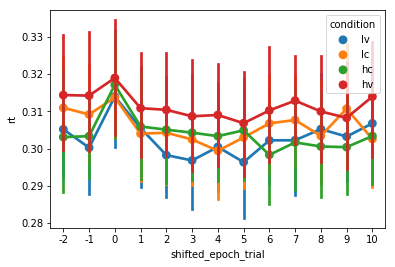

In [28]:
sns.pointplot(data=mod_df, units='ID', ci=95, x="shifted_epoch_trial", y="rt", hue='condition', estimator=stats.hmean)

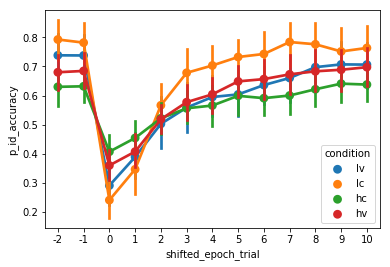

In [29]:
sns.pointplot(data=mod_df, ci=95, x="shifted_epoch_trial", y="p_id_accuracy", hue='condition', units='ID')

/Users/Krista/anaconda/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


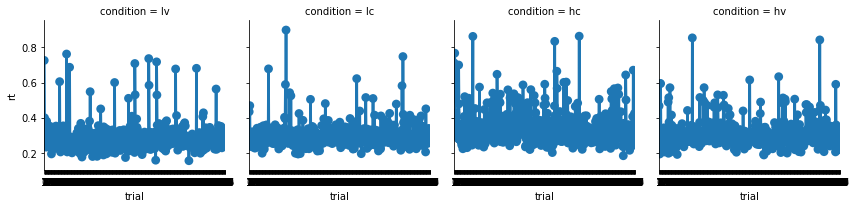

In [30]:
sample_df = cleaned_df.loc[cleaned_df.ID == "761",]
g = sns.FacetGrid(sample_df, col="condition")
g = g.map(sns.pointplot, "trial","rt")

/Users/Krista/anaconda/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


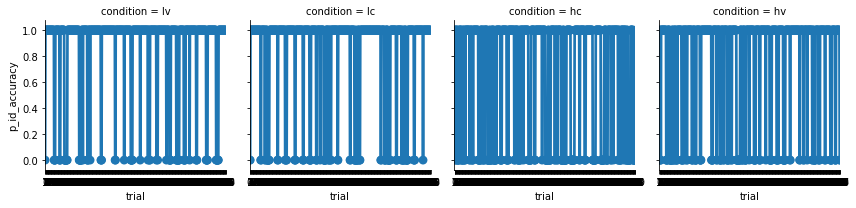

In [31]:
g = sns.FacetGrid(sample_df, col="condition")
g = g.map(sns.pointplot, "trial","p_id_accuracy")

In [32]:
##print clean df 
cleaned_df.to_csv(print_data_path + 'cleaned_probC_obs_data.csv', index = False)
##print raw df 
data_df.to_csv(print_data_path + 'raw_probC_obs_data.csv', index = False)